In [1]:
from pathlib import Path
import sys

here = Path.cwd()
repo_root = next(p for p in [here, *here.parents] if (p/"pyproject.toml").exists())
src = repo_root / "src"
if str(src) not in sys.path:
    sys.path.insert(0, str(src))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from optimal_ipr.distributions import value_distribution, build_theta_distribution
from optimal_ipr.probability import build_subjective_probability
from optimal_ipr.cost import build_cost_function
from optimal_ipr.fee import build_fee_schedule
from optimal_ipr.lookup import build_lookup_tables
from optimal_ipr.outcomes import welfare_outcomes

In [3]:
# value distribution
test_n_v = 51
test_sigma = 3.0

v_grid, v_weights = value_distribution(n_v=test_n_v, sigma=test_sigma)

Idea-Value Distribution (v)
---------------------------
Method: Lognormal with Gauss-Hermite Discretization
Number of nodes (test_n_v): 51
Target E[v]: 1.0000  |  Actual E[v]: 1.0000
Var(v): 0.9687
-----------------------------------


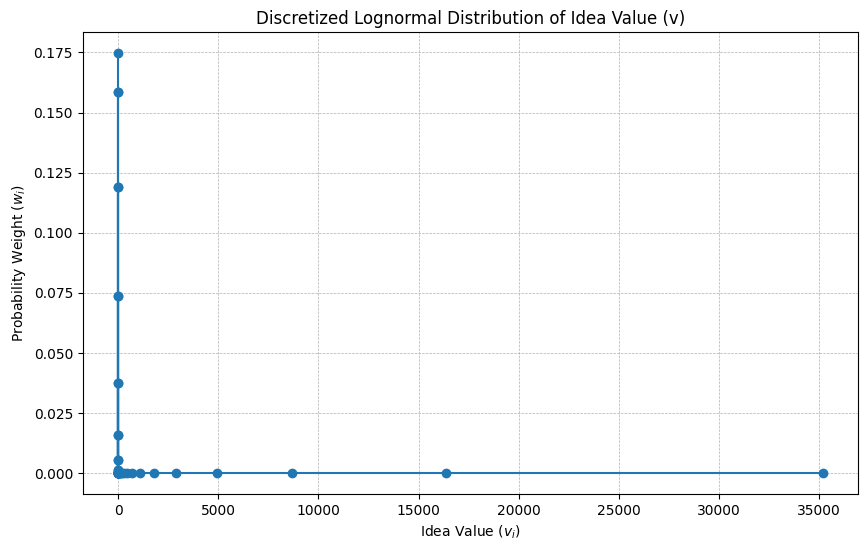

In [4]:
Ev = np.sum(v_grid * v_weights)
Var_v = np.sum((v_grid**2) * v_weights) - Ev**2
target_mean = 1.0

print(f'Idea-Value Distribution (v)')
print(f'---------------------------')
print(f"Method: Lognormal with Gauss-Hermite Discretization")
print(f"Number of nodes (test_n_v): {test_n_v}")
print(f"Target E[v]: {target_mean:.4f}  |  Actual E[v]: {Ev:.4f}")
print(f"Var(v): {Var_v:.4f}")
print(f'-' * 35)

plt.figure(figsize=(10, 6))
plt.stem(v_grid, v_weights, basefmt="-")
plt.xlabel("Idea Value ($v_i$)")
plt.ylabel("Probability Weight ($w_i$)")
plt.title("Discretized Lognormal Distribution of Idea Value (v)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [5]:
# theta distribution
f, F, F_inv = build_theta_distribution(noise_level=0.20)

# scalar wrapper for F when a scalar is required
F_scalar = lambda t: float(F(np.array([t])))

In [6]:
thresholds = [0.0, 0.05, 0.10, 0.20, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]

# Calculate the number of firms with a type greater than each threshold
firms_above = [int((1.0 - F(t)) * 29_990) for t in thresholds]

summary_df = pd.DataFrame({
    'Theta Threshold': thresholds,
    'Firms Above This Type': firms_above
})

# Apply formatting for a clean display
print("\n--- Summary of Calibrated Firm Distribution ---")
format_dict = {'Theta Threshold': '{:.4f}', 'Firms Above This Type': '{:,}'}
display(summary_df.style.format(format_dict).hide(axis="index"))


--- Summary of Calibrated Firm Distribution ---


Theta Threshold,Firms Above This Type
0.0000,"29,989"
0.0500,"26,196"
0.1000,"13,834"
0.2000,"2,726"
0.2500,"1,432"
0.5000,603
0.7500,263
0.9000,114
0.9500,65
0.9900,18


In [7]:
median_theta = F_inv(0.5)
print(f"The median theta is: {median_theta:.4f}, consistent with graphs above")

The median theta is: 0.0947, consistent with graphs above


In [8]:
p = build_subjective_probability(base_k=1.25, m_comp=5, F=F, F_inv=F_inv)

In [9]:
v_values = [0.001, 0.1, 0.5, 0.75, 1, 5, 10, 20, 100, 1000, 5000, 10000, int(max(v_grid))]
theta_thresholds = [0.0, 0.05, 0.10, 0.20, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9995, 0.9999]

table_data = {}
for v in v_values:
    table_data[f'v={v}'] = [p(theta, v) for theta in theta_thresholds]
    
df = pd.DataFrame(table_data, index=theta_thresholds)
df.index.name = r'$\theta$'
formatted_table = df.style.format("{:.2%}") \
                          .format_index("{:.4f}") \
                          .set_caption(r"Perceived winning Probability $p(\theta, v)$")

display(formatted_table)

,v=0.001,v=0.1,v=0.5,v=0.75,v=1,v=5,v=10,v=20,v=100,v=1000,v=5000,v=10000,v=35165
$\theta$,,,,,,,,,,,,,
0.0000,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.0500,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.1000,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.2000,0.04%,0.04%,0.03%,0.03%,0.03%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.2500,0.07%,0.07%,0.06%,0.06%,0.06%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.5000,0.16%,0.16%,0.15%,0.14%,0.14%,0.06%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.7500,0.37%,0.37%,0.36%,0.35%,0.34%,0.23%,0.14%,0.04%,0.00%,0.00%,0.00%,0.00%,0.00%
0.9000,0.83%,0.83%,0.82%,0.81%,0.80%,0.70%,0.57%,0.38%,0.01%,0.00%,0.00%,0.00%,0.00%
0.9500,1.41%,1.41%,1.40%,1.39%,1.39%,1.29%,1.18%,0.98%,0.16%,0.00%,0.00%,0.00%,0.00%


In [10]:
c = build_cost_function(f, TARGET_AVG_COST_SHARE=0.50, C_MIN_COST=0.05, GAMMA_C_COST=3.0)

In [11]:
Z = build_fee_schedule(zeta=0.04, fee_M=1.5)

In [11]:
tau_d_grid = np.array([0.20, 0.25, 0.30])
tau_f_grid = np.array([0.0, 0.05])
bar_beta_grid = np.linspace(0.0, 1.0, 101)  # matches earlier modules

theta_tilde_table, theta_winner_table, get_tau_d_index, get_tau_f_index, get_bar_beta_index, get_v_index = \
    build_lookup_tables(p, c, Z, f, F_scalar, tau_d_grid, tau_f_grid, bar_beta_grid, v_grid)

print(f"Value from parallel table: {theta_tilde_table[get_tau_d_index(0.20), get_tau_f_index(0.05), get_bar_beta_index(0.8), get_v_index(1.0)]:.6f}")

Processing tau pairs:   0%|          | 0/6 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
print(f"Value from parallel table: {theta_tilde_table[get_tau_d_index(0.20), get_tau_f_index(0.05), get_bar_beta_index(1), get_v_index(1.0)]:.6f}")

In [ ]:
# government weights over theta
GOVERNMENT_PREFERENCES = {
    "utilitarian":          lambda th: 1.0
}

# regulator schemes
REGULATOR_PREFERENCES = {
    "welfarist_balanced": {"phi": 0.5, "psi": 0.5}
}

results_table = welfare_outcomes(
    tau_d=tau_d_grid,
    tau_f=tau_f_grid,
    gov_prefs=GOVERNMENT_PREFERENCES,
    reg_prefs=REGULATOR_PREFERENCES,
    v_grid=v_grid,
    v_weights=v_weights,
    theta_tilde_table=theta_tilde_table,
    theta_winner_table=theta_winner_table,
    f=f,
    F=F,            # vectorized is fine; module wraps when needed
    F_inv=F_inv,
    p=p,
    c=c,
    Z=Z,
    feas=False,      # enforce feasibility
)

results_table